In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia_coronagraphy import scene, analysis, transformations

from copy import deepcopy
import numpy as np

# Constructing a Scene

Start by loading a template calculation file with only a central star and duplicate the star to create planetary companions.

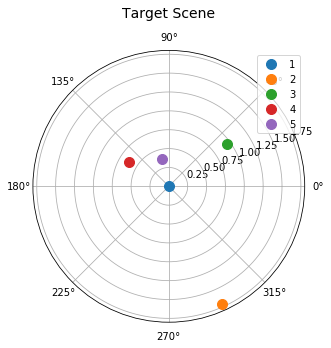

In [144]:
target = scene.load_calculation('../templates/nircam_coronagraphy_template.json')

#set instrument parameters
target['configuration']['instrument']['aperture'] = 'mask210r'
target['configuration']['instrument']['filter'] = 'f210m'
target['configuration']['detector']['ngroup'] = 7

#pull out the source dictionary for the central star
targetstar = target['scene'][0]
targetstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
targetstar['spectrum']['normalization']['norm_flux'] = 6.
targetstar['spectrum']['sed']['key'] = 'a5v'

#copy the target star and turn it into a planet
planetB = deepcopy(targetstar)
planetB['id'] = 2
planetB['position']['x_offset'] = 0.706
planetB['position']['y_offset'] = -1.563
planetB['spectrum']['normalization']['bandpass'] = 'nircam,sw_imaging,f210m'
planetB['spectrum']['normalization']['norm_flux'] = 16.3
planetB['spectrum']['normalization']['type'] = 'jwst'
planetB['spectrum']['sed']['sed_type'] = 'blackbody'
planetB['spectrum']['sed']['temp'] = 900.
del planetB['spectrum']['sed']['key']

#copy the target star and turn it into a second planet
planetC = deepcopy(targetstar)
planetC['id'] = 3
planetC['position']['x_offset'] = 0.765
planetC['position']['y_offset'] =  0.558
planetC['spectrum']['normalization']['bandpass'] = 'nircam,sw_imaging,f210m'
planetC['spectrum']['normalization']['norm_flux'] = 15.45
planetC['spectrum']['normalization']['type'] = 'jwst'
planetC['spectrum']['sed']['sed_type'] = 'blackbody'
planetC['spectrum']['sed']['temp'] = 1100.
del planetC['spectrum']['sed']['key']

#third planet
planetD = deepcopy(targetstar)
planetD['id'] = 4
planetD['position']['x_offset'] = -0.529
planetD['position']['y_offset'] = 0.323
planetD['spectrum']['normalization']['bandpass'] = 'nircam,sw_imaging,f210m'
planetD['spectrum']['normalization']['norm_flux'] = 15.30
planetD['spectrum']['normalization']['type'] = 'jwst'
planetD['spectrum']['sed']['sed_type'] = 'blackbody'
planetD['spectrum']['sed']['temp'] = 1100.
del planetD['spectrum']['sed']['key']

#and, finally, a fourth
planetE = deepcopy(targetstar)
planetE['id'] = 5
planetE['position']['x_offset'] = -0.09
planetE['position']['y_offset'] = 0.366
planetE['spectrum']['normalization']['bandpass'] = 'nircam,sw_imaging,f210m'
planetE['spectrum']['normalization']['norm_flux'] = 15.30
planetE['spectrum']['normalization']['type'] = 'jwst'
planetE['spectrum']['sed']['sed_type'] = 'blackbody'
planetE['spectrum']['sed']['temp'] = 1000.
del planetE['spectrum']['sed']['key']

#update calculation file with new sources
target['scene'].extend([planetB,planetC,planetD,planetE])

scene.plot_scene(target['scene'],'Target Scene')

Now we'll rotate the scene and add in a global offset due to target acquisition error.

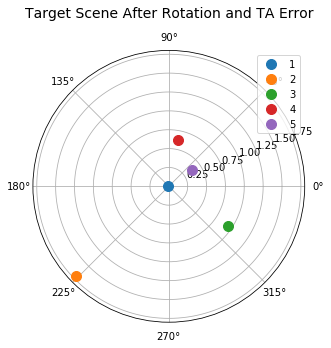

In [145]:
scene.rotate_scene(target['scene'],70.,center=[0.,0.])
errx, erry = scene.get_ta_error()
scene.offset_scene(target['scene'],errx,erry)

scene.plot_scene(target['scene'],'Target Scene After Rotation and TA Error')

For the reference PSF, we'll create a scene with a companionless star.

(0, 0.7)

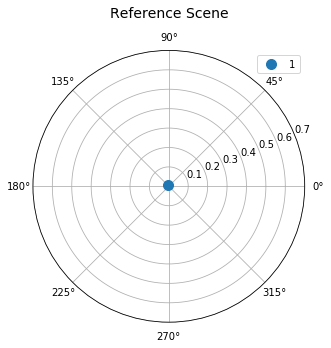

In [146]:
reference = scene.load_calculation('../templates/nircam_coronagraphy_template.json')

# set the sameinstrument parameters
reference['configuration']['instrument']['aperture'] = 'mask210r'
reference['configuration']['instrument']['filter'] = 'f210m'
reference['configuration']['detector']['ngroup'] = 5

# we adopt a brighter but spectrally-mismatched reference
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
refstar['spectrum']['normalization']['norm_flux'] = 4.8
refstar['spectrum']['sed']['key'] = 'a3v'

# and a unique TA error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)

scene.plot_scene(reference['scene'],'Reference Scene')
ax = plt.gca()
ax.set_rlim(0,0.7)

# Run the Pandeia Engine

Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

The most direct way to do so is to pass the calculation file to ```pandeia.engine.perform_calculation.``` However, because the calculation is fairly time-consuming, ```scene.calculate_batch``` is provided as a convenience function for easy parallelization.

In [132]:
targ_results, ref_results = scene.calculate_batch([target,reference])

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


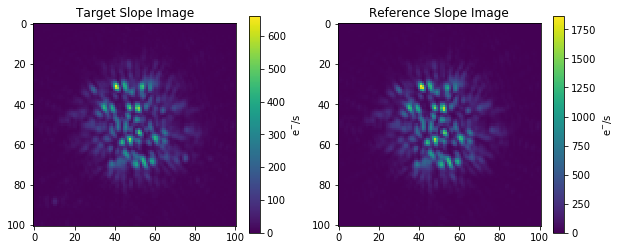

In [151]:
target_slope = targ_results['2d']['detector']
reference_slope = ref_results['2d']['detector']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(target_slope)
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(reference_slope)
plt.title('Reference Slope Image')
plt.colorbar().set_label('e$^{-}$/s')

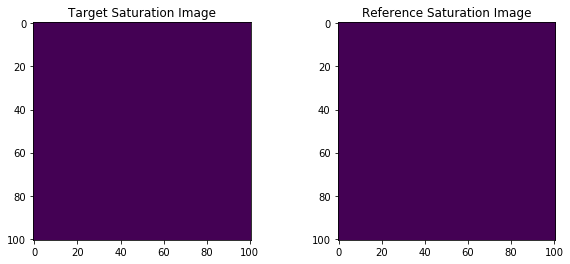

In [152]:
target_sat = targ_results['2d']['saturation']
reference_sat = ref_results['2d']['saturation']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(target_sat)
plt.title('Target Saturation Image')
plt.subplot(122)
plt.imshow(reference_sat)
plt.title('Reference Saturation Image')

# Post-Processing

Subtract the registered and scaled reference PSF from the target image.

In [153]:
centered_target = target_slope - np.nanmean(target_slope)
centered_reference = reference_slope - np.nanmean(reference_slope)
centered_reference[np.isnan(centered_reference)] = np.nanmax(centered_reference)

registered_ref = analysis.register_to_target(centered_reference,centered_target)

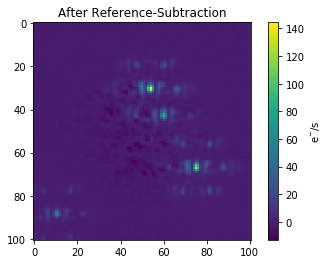

In [154]:
plt.imshow(centered_target - registered_ref)
plt.colorbar().set_label('e$^{-}$/s')
plt.title('After Reference-Subtraction')

# Save Calculation File

Save out your scene and instrument parameters for quick-loading with a future call to ```scene.load_calculation```

In [124]:
scene.save_calculation(target,'mygreatcalculation.json')

# More Complicated Things: Small-Grid Dithers and KLIP

To simulate a small-grid dither (SGD), pass in a reference calculation file (after adding TA error) to the ```scene.create_SGD``` function. By default, this only supports a square 9-point grid with 2 mas error on the grid points, but this function can be easily reproduced for other SGD configurations.

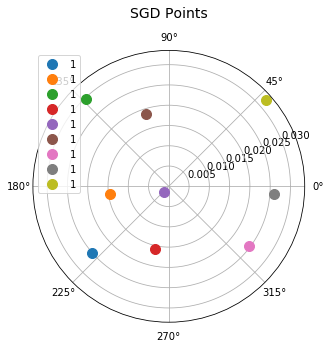

In [137]:
#set up the same reference
reference = scene.load_calculation('../templates/nircam_coronagraphy_template.json')

# set the sameinstrument parameters
reference['configuration']['instrument']['aperture'] = 'mask210r'
reference['configuration']['instrument']['filter'] = 'f210m'
reference['configuration']['detector']['ngroup'] = 5

# we adopt a brighter but spectrally-mismatched reference
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
refstar['spectrum']['normalization']['norm_flux'] = 4.8
refstar['spectrum']['sed']['key'] = 'a3v'

# and a unique TA error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)

sgds = scene.create_SGD(reference,stepsize=20.e-3)

plt.figure(figsize=(5,5))
for s in sgds:
    scene.plot_scene(s['scene'],'SGD Points',newfig=False)

Pass the SGD list to the pandeia engine

In [138]:
sgd_results = scene.calculate_batch(sgds)

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/pyt

After registering the SGD observations to the target image, treat the SGD results as a reference library for KLIP and generate an artificial PSF for reference-subtraction

In [139]:
sgd_reg = []
for r in sgd_results:
    slope = r['2d']['detector']
    centered_slope = slope - np.mean(slope)
    reg = analysis.register_to_target(centered_slope,centered_target)
    sgd_reg.append(reg)
sgd_reg = np.array(sgd_reg)

artificialPSF = analysis.klip_projection(centered_target,sgd_reg)

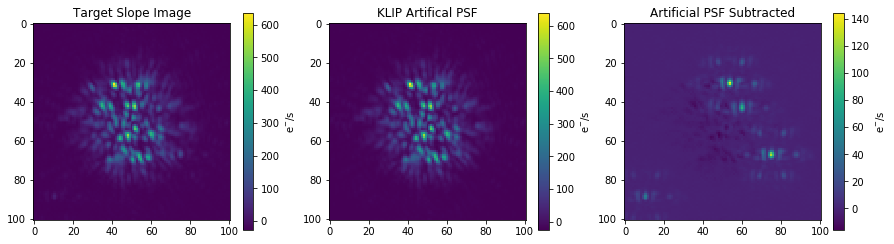

In [140]:
sgd_sub = centered_target - artificialPSF

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(centered_target)
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(artificialPSF)
plt.title('KLIP Artifical PSF')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(sgd_sub)
plt.title('Artificial PSF Subtracted')
plt.colorbar().set_label('e$^{-}$/s')